1. Настраиваем окружение
2. Загружаем датасет `dota.ttl`, извлекаем табличные представления.
3. Предобрабатываем и разбиваем данные на `train/test` по воспроизводимому критерию.
4. Преобразуем данные в набор RDF-триплетов (head, relation, tail).
5. Обучаем модель векторных представлений KG (TransE).
6. Оцениваем модель метриками MR/MRR/Hits@K.
7. Используем эмбеддинги для кластеризации и классификации.
8. Решаем задачу link prediction (предсказание недостающих связей) для `usesItem_<phase>`.

критерий разбиения задаётся числовым порогом `gamesPlayed`, `pickCount`


## 1) Окружение

In [ ]:
!pip -q install -r requirements.txt


In [ ]:
from __future__ import annotations

import json
import math
import os
import random
from collections import Counter, defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Sequence

import numpy as np
import pandas as pd
import torch
from rdflib import Graph, Namespace
from rdflib.namespace import RDF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from tqdm.auto import tqdm
from xgboost import XGBClassifier

DOTA = Namespace("http://dota2.ontology#")

print("torch:", torch.__version__)


torch: 2.9.0+cu126


### Параметры запуска

In [ ]:
TTL_PATH = Path("dota.ttl")
OUT_DIR = Path("outputs_notebook")

SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MATCHUP_QUANTILE = 0.25
ITEM_QUANTILE = 0.5

KGE_TRAIN_RATIO = 0.8

DIM = 64
EPOCHS = 750
BATCH_SIZE = 1024
LR = 1e-3
MARGIN = 1.0
NEG_PER_POS = 4

EVAL_NEGATIVES = 50
TEST_NEGATIVES = 50

FAST_MODE = False
if FAST_MODE:
    EPOCHS = 2
    EVAL_NEGATIVES = 5
    TEST_NEGATIVES = 5

print("DEVICE:", DEVICE)
print("FAST_MODE:", FAST_MODE)


DEVICE: cuda
FAST_MODE: False


### Вспомогательные функции

In [ ]:
@dataclass(frozen=True)
class MatchupRow:
    for_hero: str
    vs_hero: str
    vs_win_rate: float
    games_played: int


@dataclass(frozen=True)
class ItemUsageRow:
    hero: str
    item: str
    pick_count: int
    phase: str


@dataclass(frozen=True)
class HeroRow:
    hero: str
    primary_attr: str
    role: str
    team: str


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def uri_to_id(uri: str) -> str:
    if "#" in uri:
        return uri.split("#", 1)[1]
    return uri.rsplit("/", 1)[-1]


def compute_quantile_threshold(values: Sequence[int], q: float) -> int:
    if not values:
        raise ValueError("Cannot compute threshold for an empty list.")
    if not (0.0 <= q <= 1.0):
        raise ValueError("q must be in [0, 1].")
    return int(np.quantile(np.asarray(values, dtype=np.int64), q))


def matchup_label_3class(vs_win_rate: float) -> str:
    if vs_win_rate >= 0.52:
        return "adv"
    if vs_win_rate <= 0.48:
        return "dis"
    return "even"


set_seed(SEED)


## 2) Загрузка датасета и извлечение данных

Читаем `dota.ttl` как RDF-граф и извлекаем три типа табличных сущностей:

- `Hero` (атрибуты/роль/команда),
- `HeroMatchup` (пары героев, winrate, gamesPlayed),
- `HeroItemUsage` (герой, предмет, частота, фаза).

На этом же шаге реализовано удаление строк с null

In [ ]:
def load_ttl(ttl_path: Path) -> Graph:
    g = Graph()
    g.parse(str(ttl_path), format="turtle")
    return g


def extract_heroes(g: Graph) -> list[HeroRow]:
    heroes: list[HeroRow] = []
    for h in g.subjects(RDF.type, DOTA.Hero):
        primary_attr = next(g.objects(h, DOTA.hasPrimaryAttribute), None)
        role = next(g.objects(h, DOTA.hasRole), None)
        team = next(g.objects(h, DOTA.belongsToTeam), None)
        if primary_attr is None or role is None or team is None:
            continue
        heroes.append(
            HeroRow(
                hero=str(h),
                primary_attr=str(primary_attr),
                role=str(role),
                team=str(team),
            )
        )
    return heroes


def extract_matchups(g: Graph) -> list[MatchupRow]:
    rows: list[MatchupRow] = []
    for hm in g.subjects(RDF.type, DOTA.HeroMatchup):
        for_hero = next(g.objects(hm, DOTA.forHero), None)
        vs_hero = next(g.objects(hm, DOTA.vsHero), None)
        vs_win_rate = next(g.objects(hm, DOTA.vsWinRate), None)
        games_played = next(g.objects(hm, DOTA.gamesPlayed), None)
        if for_hero is None or vs_hero is None or vs_win_rate is None or games_played is None:
            continue
        rows.append(
            MatchupRow(
                for_hero=str(for_hero),
                vs_hero=str(vs_hero),
                vs_win_rate=float(vs_win_rate),
                games_played=int(games_played),
            )
        )
    return rows


def extract_item_usage(g: Graph) -> list[ItemUsageRow]:
    rows: list[ItemUsageRow] = []
    for hiu in g.subjects(RDF.type, DOTA.HeroItemUsage):
        hero = next(g.objects(hiu, DOTA.forHero), None)
        item = next(g.objects(hiu, DOTA.usesItem), None)
        pick_count = next(g.objects(hiu, DOTA.pickCount), None)
        phase = next(g.objects(hiu, DOTA.inPhase), None)
        if hero is None or item is None or pick_count is None or phase is None:
            continue
        rows.append(
            ItemUsageRow(
                hero=str(hero),
                item=str(item),
                pick_count=int(pick_count),
                phase=str(phase),
            )
        )
    return rows


In [ ]:
if not TTL_PATH.exists():
    raise FileNotFoundError(f"Не найден файл датасета: {TTL_PATH.resolve()}")

g = load_ttl(TTL_PATH)
heroes = extract_heroes(g)
matchups = extract_matchups(g)
item_usage = extract_item_usage(g)

print("[data] heroes=", len(heroes), "matchups=", len(matchups), "item_usage=", len(item_usage))

heroes_df = pd.DataFrame([h.__dict__ for h in heroes])
matchups_df = pd.DataFrame([m.__dict__ for m in matchups])
items_df = pd.DataFrame([x.__dict__ for x in item_usage])

display(heroes_df.head())
display(matchups_df.head())
display(items_df.head())


[data] heroes= 126 matchups= 15734 item_usage= 12308


,hero,primary_attr,role,team
0,http://dota2.ontology#AntiMage,http://dota2.ontology#Agility,http://dota2.ontology#Carry,http://dota2.ontology#Dire
1,http://dota2.ontology#Axe,http://dota2.ontology#Strength,http://dota2.ontology#Offlane,http://dota2.ontology#Radiant
2,http://dota2.ontology#Bane,http://dota2.ontology#Universal,http://dota2.ontology#Carry,http://dota2.ontology#Dire
3,http://dota2.ontology#Bloodseeker,http://dota2.ontology#Agility,http://dota2.ontology#Carry,http://dota2.ontology#Radiant
4,http://dota2.ontology#CrystalMaiden,http://dota2.ontology#Intelligence,http://dota2.ontology#HardSupport,http://dota2.ontology#Dire


,for_hero,vs_hero,vs_win_rate,games_played
0,http://dota2.ontology#AntiMage,http://dota2.ontology#OgreMagi,0.3759,133
1,http://dota2.ontology#AntiMage,http://dota2.ontology#Rubick,0.4065,123
2,http://dota2.ontology#AntiMage,http://dota2.ontology#Medusa,0.5299,117
3,http://dota2.ontology#AntiMage,http://dota2.ontology#QueenofPain,0.4914,116
4,http://dota2.ontology#AntiMage,http://dota2.ontology#Morphling,0.4074,108


,hero,item,pick_count,phase
0,http://dota2.ontology#AntiMage,http://dota2.ontology#QuellingBlade,64,start_game_items
1,http://dota2.ontology#AntiMage,http://dota2.ontology#GauntletsofStrength,2,start_game_items
2,http://dota2.ontology#AntiMage,http://dota2.ontology#SlippersofAgility,18,start_game_items
3,http://dota2.ontology#AntiMage,http://dota2.ontology#IronBranch,241,start_game_items
4,http://dota2.ontology#AntiMage,http://dota2.ontology#Circlet,41,start_game_items


## 3) Разбиение train/test и преобразование в триплеты

Критерий разбиения:

- матчапы: по `gamesPlayed` (квантиль `MATCHUP_QUANTILE`),
- предметы: по `pickCount` (квантиль `ITEM_QUANTILE`).

Далее формируем триплеты:

- статические факты о героях (train),
- `(Hero, hasAbility, Ability)` и типизация способностей (train),
- матчапы `(forHero, matchupAgainst, vsHero)` (train/test),
- предметы `(Hero, usesItem_<phase>, Item)` (train/test),
- типизация предметов `(Item, rdf:type, Item)` (train).

Также выполняется "cleanup": переносим из `test` в `train` триплеты, содержащие сущности, которых нет в `train` (иначе KGE не сможет их оценить).

In [ ]:
def build_triples(
    heroes: Sequence[HeroRow],
    matchups: Sequence[MatchupRow],
    item_usage: Sequence[ItemUsageRow],
    matchup_games_threshold: int,
    item_pick_threshold: int,
) -> tuple[list[tuple[str, str, str]], list[tuple[str, str, str]]]:
    train: list[tuple[str, str, str]] = []
    test: list[tuple[str, str, str]] = []

    # Статические факты о героях (train)
    for row in heroes:
        train.append((row.hero, str(RDF.type), str(DOTA.Hero)))
        train.append((row.hero, str(DOTA.hasPrimaryAttribute), row.primary_attr))
        train.append((row.hero, str(DOTA.belongsToTeam), row.team))

    # Матчапы
    matchup_rel = str(DOTA.matchupAgainst)
    for m in matchups:
        target = train if m.games_played >= matchup_games_threshold else test
        target.append((m.for_hero, matchup_rel, m.vs_hero))

    # Предметы (фаза кодируется в имени отношения)
    for iu in item_usage:
        rel = str(DOTA[f"usesItem_{iu.phase}"])
        target = train if iu.pick_count >= item_pick_threshold else test
        target.append((iu.hero, rel, iu.item))

    train = sorted(set(train))
    test = sorted(set(test))
    return train, test


def add_ability_triples_from_graph(g: Graph, train_triples: list[tuple[str, str, str]]) -> list[tuple[str, str, str]]:
    extra: list[tuple[str, str, str]] = []
    abilities: set[str] = set()
    for hero in g.subjects(RDF.type, DOTA.Hero):
        for ability in g.objects(hero, DOTA.hasAbility):
            extra.append((str(hero), str(DOTA.hasAbility), str(ability)))
            abilities.add(str(ability))
    for ability in abilities:
        extra.append((ability, str(RDF.type), str(DOTA.Ability)))
    return sorted(set(train_triples).union(extra))


def add_item_type_triples_from_graph(g: Graph, triples: list[tuple[str, str, str]]) -> list[tuple[str, str, str]]:
    prefix = str(DOTA) + "usesItem_"
    used_items = {t for _, r, t in triples if r.startswith(prefix)}
    extra = [(it, str(RDF.type), str(DOTA.Item)) for it in used_items]
    return sorted(set(triples).union(extra))


def ensure_test_entities_in_train(
    train_triples: Sequence[tuple[str, str, str]],
    test_triples: Sequence[tuple[str, str, str]],
) -> tuple[list[tuple[str, str, str]], list[tuple[str, str, str]], int]:
    train_set = set(train_triples)
    test_set = set(test_triples)

    def entities(trs: Iterable[tuple[str, str, str]]) -> set[str]:
        out: set[str] = set()
        for h, _, t in trs:
            out.add(h)
            out.add(t)
        return out

    moved = 0
    train_entities = entities(train_set)
    changed = True
    while changed:
        changed = False
        for tr in list(test_set):
            h, _, t = tr
            if h in train_entities and t in train_entities:
                continue
            test_set.remove(tr)
            train_set.add(tr)
            train_entities.add(h)
            train_entities.add(t)
            moved += 1
            changed = True

    return sorted(train_set), sorted(test_set), moved


def export_triples_tsv(triples: Sequence[tuple[str, str, str]], path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for h, r, t in triples:
            f.write(f"{h}\\t{r}\\t{t}\\n")


In [ ]:
matchup_threshold = compute_quantile_threshold([m.games_played for m in matchups], MATCHUP_QUANTILE)
item_threshold = compute_quantile_threshold([x.pick_count for x in item_usage], ITEM_QUANTILE)

print(f"[split] matchups quantile={MATCHUP_QUANTILE} -> gamesPlayed threshold={matchup_threshold}")
print(f"[split] items quantile={ITEM_QUANTILE} -> pickCount threshold={item_threshold}")

train_triples, test_triples = build_triples(
    heroes=heroes,
    matchups=matchups,
    item_usage=item_usage,
    matchup_games_threshold=matchup_threshold,
    item_pick_threshold=item_threshold,
)
train_triples = add_ability_triples_from_graph(g, train_triples)

train_triples, test_triples, moved = ensure_test_entities_in_train(train_triples, test_triples)
if moved:
    print(f"[split] moved {moved} triples from test to train (unseen entities cleanup)")

train_triples = add_item_type_triples_from_graph(g, train_triples)

print("[triples] train=", len(train_triples), "test=", len(test_triples))
print("sample train triple:", train_triples[0])
print("sample test triple:", test_triples[0] if test_triples else None)

# (Опционально) сохранить в файлы
OUT_DIR.mkdir(parents=True, exist_ok=True)
export_triples_tsv(train_triples, OUT_DIR / "triples_train.tsv")
export_triples_tsv(test_triples, OUT_DIR / "triples_test.tsv")


[split] matchups quantile=0.25 -> gamesPlayed threshold=31
[split] items quantile=0.5 -> pickCount threshold=4
[split] moved 4 triples from test to train (unseen entities cleanup)
[triples] train= 19875 test= 9616
sample train triple: ('http://dota2.ontology#10Damage', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'http://dota2.ontology#Ability')
sample test triple: ('http://dota2.ontology#Abaddon', 'http://dota2.ontology#matchupAgainst', 'http://dota2.ontology#ArcWarden')


## 4) Подготовка к обучению KGE (разбиение train на train_kge/eval_kge, маппинги)

разделяем `train` на две части так, чтобы **все сущности** были представлены в обеих выборках (для корректной оценки).

In [ ]:
def split_with_entity_coverage(
    triples: Sequence[tuple[str, str, str]],
    train_ratio: float,
    seed: int,
    max_passes: int = 25,
) -> tuple[list[tuple[str, str, str]], list[tuple[str, str, str]]]:
    if not (0.0 < train_ratio < 1.0):
        raise ValueError("train_ratio must be in (0, 1).")

    rng = random.Random(seed)
    triples_list = list(triples)
    rng.shuffle(triples_list)

    cut = int(len(triples_list) * train_ratio)
    a = triples_list[:cut]
    b = triples_list[cut:]

    def entities(ts: Iterable[tuple[str, str, str]]) -> set[str]:
        s = set()
        for h, _, t in ts:
            s.add(h)
            s.add(t)
        return s

    a_set = set(a)
    b_set = set(b)

    for _ in range(max_passes):
        ea = entities(a_set)
        eb = entities(b_set)
        missing_in_a = eb - ea
        missing_in_b = ea - eb
        if not missing_in_a and not missing_in_b:
            break

        def move_one(missing: set[str], src: set[tuple[str, str, str]], dst: set[tuple[str, str, str]]) -> int:
            moved = 0
            if not missing:
                return moved
            idx: dict[str, list[tuple[str, str, str]]] = defaultdict(list)
            for h, r, t in src:
                idx[h].append((h, r, t))
                idx[t].append((h, r, t))
            for ent in list(missing):
                candidates = idx.get(ent, [])
                if not candidates:
                    continue
                tr = rng.choice(candidates)
                src.remove(tr)
                dst.add(tr)
                moved += 1
            return moved

        moved = 0
        moved += move_one(missing_in_a, b_set, a_set)
        moved += move_one(missing_in_b, a_set, b_set)
        if moved == 0:
            break

    ea = entities(a_set)
    eb = entities(b_set)
    if ea != eb:
        common = ea & eb
        a_set = {tr for tr in a_set if tr[0] in common and tr[2] in common}
        b_set = {tr for tr in b_set if tr[0] in common and tr[2] in common}

    return sorted(a_set), sorted(b_set)


@dataclass
class Mappings:
    entity_to_id: dict[str, int]
    relation_to_id: dict[str, int]
    id_to_entity: list[str]
    id_to_relation: list[str]


def build_mappings(triples: Sequence[tuple[str, str, str]]) -> Mappings:
    entities = sorted({x for h, _, t in triples for x in (h, t)})
    relations = sorted({r for _, r, _ in triples})
    entity_to_id = {e: i for i, e in enumerate(entities)}
    relation_to_id = {r: i for i, r in enumerate(relations)}
    return Mappings(entity_to_id, relation_to_id, entities, relations)


def triples_to_tensor(triples: Sequence[tuple[str, str, str]], m: Mappings) -> torch.LongTensor:
    arr = np.zeros((len(triples), 3), dtype=np.int64)
    for i, (h, r, t) in enumerate(triples):
        arr[i, 0] = m.entity_to_id[h]
        arr[i, 1] = m.relation_to_id[r]
        arr[i, 2] = m.entity_to_id[t]
    return torch.from_numpy(arr)


In [ ]:
train_kge, eval_kge = split_with_entity_coverage(train_triples, train_ratio=KGE_TRAIN_RATIO, seed=SEED)
print("[kge split] train_kge=", len(train_kge), "eval_kge=", len(eval_kge))

mappings = build_mappings(train_triples)
train_tensor = triples_to_tensor(train_kge, mappings)
eval_tensor = triples_to_tensor(eval_kge, mappings)
test_tensor = triples_to_tensor(test_triples, mappings) if test_triples else torch.empty((0, 3), dtype=torch.long)

print("[mappings] entities=", len(mappings.id_to_entity), "relations=", len(mappings.id_to_relation))


[kge split] train_kge= 15614 eval_kge= 4261
[mappings] entities= 734 relations= 9


## 5) Обучение модели векторных представлений KG (TransE)

Обучаем TransE с negative sampling и margin ranking loss.

In [ ]:
class TransE(torch.nn.Module):
    def __init__(self, num_entities: int, num_relations: int, dim: int) -> None:
        super().__init__()
        self.entity = torch.nn.Embedding(num_entities, dim)
        self.relation = torch.nn.Embedding(num_relations, dim)
        torch.nn.init.xavier_uniform_(self.entity.weight)
        torch.nn.init.xavier_uniform_(self.relation.weight)

    def score(self, h: torch.Tensor, r: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return -torch.linalg.vector_norm(h + r - t, ord=1, dim=-1)

    def forward(self, heads: torch.Tensor, rels: torch.Tensor, tails: torch.Tensor) -> torch.Tensor:
        h = self.entity(heads)
        r = self.relation(rels)
        t = self.entity(tails)
        return self.score(h, r, t)


def train_transe(
    train_triples: torch.LongTensor,
    num_entities: int,
    num_relations: int,
    dim: int,
    epochs: int,
    batch_size: int,
    lr: float,
    margin: float,
    neg_per_pos: int,
    seed: int,
    device: torch.device,
) -> TransE:
    set_seed(seed)
    model = TransE(num_entities=num_entities, num_relations=num_relations, dim=dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MarginRankingLoss(margin=margin)

    train_triples = train_triples.to(device)
    num = train_triples.shape[0]
    indices = torch.arange(num, device=device)

    for epoch in range(1, epochs + 1):
        perm = indices[torch.randperm(num, device=device)]
        total_loss = 0.0
        model.train()

        for start in range(0, num, batch_size):
            batch_idx = perm[start : start + batch_size]
            pos = train_triples[batch_idx]
            pos_h = pos[:, 0]
            pos_r = pos[:, 1]
            pos_t = pos[:, 2]

            neg = pos.repeat_interleave(neg_per_pos, dim=0)
            corrupt_head = torch.rand((neg.shape[0],), device=device) < 0.5
            random_entities = torch.randint(0, num_entities, (neg.shape[0],), device=device)
            neg[corrupt_head, 0] = random_entities[corrupt_head]
            neg[~corrupt_head, 2] = random_entities[~corrupt_head]

            neg_h = neg[:, 0]
            neg_r = neg[:, 1]
            neg_t = neg[:, 2]

            pos_scores = model(pos_h, pos_r, pos_t)
            neg_scores = model(neg_h, neg_r, neg_t)

            pos_scores_rep = pos_scores.repeat_interleave(neg_per_pos)
            y = torch.ones_like(pos_scores_rep)
            loss = loss_fn(pos_scores_rep, neg_scores, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += float(loss.detach().cpu())

        avg = total_loss / max(1, math.ceil(num / batch_size))
        if epoch == 1 or epoch % 5 == 0 or epoch == epochs:
            print(f"[train] epoch={epoch}/{epochs} loss={avg:.4f}")

    return model


In [ ]:
model = train_transe(
    train_triples=train_tensor,
    num_entities=len(mappings.id_to_entity),
    num_relations=len(mappings.id_to_relation),
    dim=DIM,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    margin=MARGIN,
    neg_per_pos=NEG_PER_POS,
    seed=SEED,
    device=DEVICE,
)


[train] epoch=1/750 loss=0.8887
[train] epoch=5/750 loss=0.2001
[train] epoch=10/750 loss=0.1577
[train] epoch=15/750 loss=0.1500
[train] epoch=20/750 loss=0.1429
[train] epoch=25/750 loss=0.1389
[train] epoch=30/750 loss=0.1334
[train] epoch=35/750 loss=0.1346
[train] epoch=40/750 loss=0.1317
[train] epoch=45/750 loss=0.1306
[train] epoch=50/750 loss=0.1276
[train] epoch=55/750 loss=0.1254
[train] epoch=60/750 loss=0.1214
[train] epoch=65/750 loss=0.1281
[train] epoch=70/750 loss=0.1245
[train] epoch=75/750 loss=0.1221
[train] epoch=80/750 loss=0.1212
[train] epoch=85/750 loss=0.1198
[train] epoch=90/750 loss=0.1196
[train] epoch=95/750 loss=0.1163
[train] epoch=100/750 loss=0.1149
[train] epoch=105/750 loss=0.1158
[train] epoch=110/750 loss=0.1169
[train] epoch=115/750 loss=0.1159
[train] epoch=120/750 loss=0.1138
[train] epoch=125/750 loss=0.1148
[train] epoch=130/750 loss=0.1143
[train] epoch=135/750 loss=0.1122
[train] epoch=140/750 loss=0.1124
[train] epoch=145/750 loss=0.1120
[t

## 6) Оценка KGE: MR / MRR / Hits@K

Оценка ранжированием: для каждого истинного триплета генерируем N негативных, фильтруем по полному `train` и считаем ранг истинного.

In [ ]:
def rank_metrics_from_ranks(ranks: Sequence[int], hits_ks: Sequence[int] = (1, 3, 10)) -> dict[str, float]:
    ranks_arr = np.asarray(ranks, dtype=np.float64)
    mr = float(ranks_arr.mean()) if ranks_arr.size else float("nan")
    mrr = float((1.0 / ranks_arr).mean()) if ranks_arr.size else float("nan")
    out: dict[str, float] = {"MR": mr, "MRR": mrr}
    for k in hits_ks:
        out[f"Hits@{k}"] = float((ranks_arr <= k).mean()) if ranks_arr.size else float("nan")
    return out


def evaluate_ranking(
    model: TransE,
    triples_eval: torch.LongTensor,
    all_train_triples_set: set[tuple[int, int, int]],
    num_entities: int,
    num_negatives: int,
    seed: int,
    device: torch.device,
) -> tuple[list[int], pd.DataFrame]:
    rng = random.Random(seed)
    model.eval()
    triples_eval = triples_eval.to(device)

    ranks: list[int] = []
    records: list[dict[str, int | float]] = []

    for i in tqdm(range(triples_eval.shape[0]), desc="eval", leave=False):
        h, r, t = map(int, triples_eval[i].tolist())

        candidates: list[tuple[int, int, int]] = [(h, r, t)]
        attempts = 0
        while len(candidates) < 1 + num_negatives and attempts < (1 + num_negatives) * 50:
            attempts += 1
            corrupt_head = rng.random() < 0.5
            e = rng.randrange(num_entities)
            cand = (e, r, t) if corrupt_head else (h, r, e)
            if cand in all_train_triples_set:
                continue
            candidates.append(cand)

        cand_tensor = torch.tensor(candidates, dtype=torch.long, device=device)
        scores = model(cand_tensor[:, 0], cand_tensor[:, 1], cand_tensor[:, 2]).detach().cpu().numpy()
        true_score = float(scores[0])
        rank = 1 + int(np.sum(scores[1:] > true_score))
        ranks.append(rank)
        records.append({"idx": i, "rank": rank, "true_score": true_score, "num_candidates": len(candidates)})

    return ranks, pd.DataFrame.from_records(records)


In [ ]:
train_all_set = set(map(tuple, triples_to_tensor(train_triples, mappings).cpu().numpy().tolist()))

eval_ranks, eval_df = evaluate_ranking(
    model=model,
    triples_eval=eval_tensor,
    all_train_triples_set=train_all_set,
    num_entities=len(mappings.id_to_entity),
    num_negatives=EVAL_NEGATIVES,
    seed=SEED,
    device=DEVICE,
)
metrics_eval = rank_metrics_from_ranks(eval_ranks)

print("[eval]", metrics_eval)

# (Опционально) сохранить
(eval_df).to_csv(OUT_DIR / "eval_ranks.csv", index=False)
with (OUT_DIR / "metrics_eval.json").open("w", encoding="utf-8") as f:
    json.dump(metrics_eval, f, ensure_ascii=False, indent=2)


eval:   0%|          | 0/4261 [00:00<?, ?it/s]

[eval] {'MR': 2.877962919502464, 'MRR': 0.7439177649703569, 'Hits@1': 0.6245012907768129, 'Hits@3': 0.8390049284205585, 'Hits@10': 0.9335836658061488}


## 7) Кластеризация (KMeans) и визуализация (PCA)

Кластеризуем героев по их эмбеддингам `e(Hero)` и сравниваем с истинными метками (роль). Качество оцениваем `adjusted rand score (ARI)`.

Также строим интерпретируемый baseline: кластеризация героев по профилям предметов.

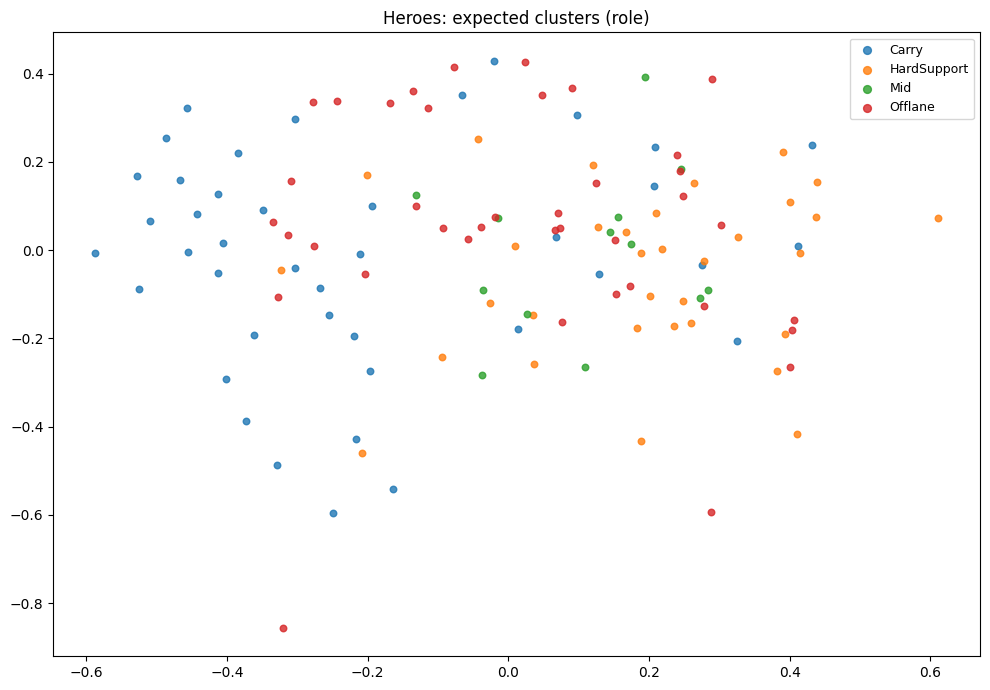

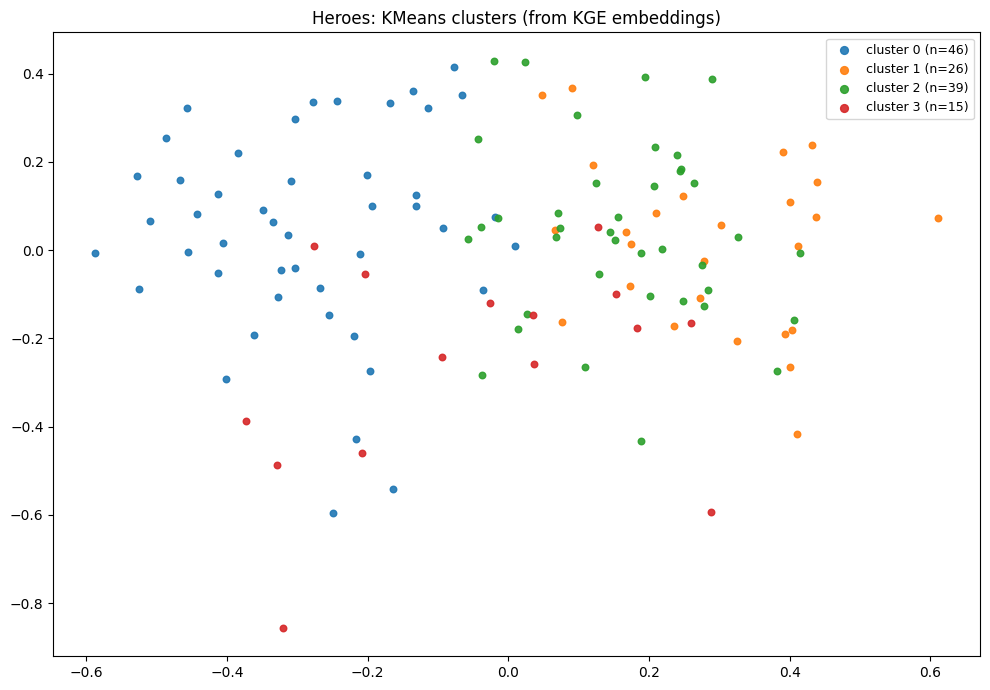

[cluster] ARI= 0.1095085009907515


In [ ]:
import matplotlib.pyplot as plt


def get_entity_embeddings(model: TransE) -> np.ndarray:
    return model.entity.weight.detach().cpu().numpy()


# --- Кластеризация по эмбеддингам KGE
from rdflib import URIRef

heroes_uris = [str(h) for h in g.subjects(RDF.type, DOTA.Hero) if str(h) in mappings.entity_to_id]
labels_role = []
for h in heroes_uris:
    role = next(g.objects(URIRef(h), DOTA.hasRole), None)
    labels_role.append(uri_to_id(str(role)) if role is not None else "UNKNOWN")

unique_labels = sorted(set(labels_role))
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}
y_true = np.array([label_to_int[x] for x in labels_role], dtype=np.int64)

emb = get_entity_embeddings(model)
X = np.stack([emb[mappings.entity_to_id[h]] for h in heroes_uris], axis=0)

pca = PCA(n_components=2, random_state=SEED)
X2 = pca.fit_transform(X)

# Визуализация ожидаемых кластеров (роль)
plt.figure(figsize=(10, 7))
for lab in unique_labels:
    idx = [i for i, x in enumerate(labels_role) if x == lab]
    plt.scatter(X2[idx, 0], X2[idx, 1], s=22, alpha=0.8, label=lab)
plt.title("Heroes: expected clusters (role)")
plt.legend(markerscale=1.2, fontsize=9)
plt.tight_layout()
plt.show()

# KMeans по эмбеддингам
n_clusters = len(unique_labels)
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init="auto")
y_pred = kmeans.fit_predict(X)

plt.figure(figsize=(10, 7))
for cid in range(n_clusters):
    idx = np.where(y_pred == cid)[0]
    if idx.size == 0:
        continue
    plt.scatter(X2[idx, 0], X2[idx, 1], s=22, alpha=0.9, label=f"cluster {cid} (n={idx.size})")
plt.title("Heroes: KMeans clusters (from KGE embeddings)")
plt.legend(markerscale=1.2, fontsize=9)
plt.tight_layout()
plt.show()

ari_kge = float(adjusted_rand_score(y_true, y_pred))
print("[cluster] ARI=", ari_kge)


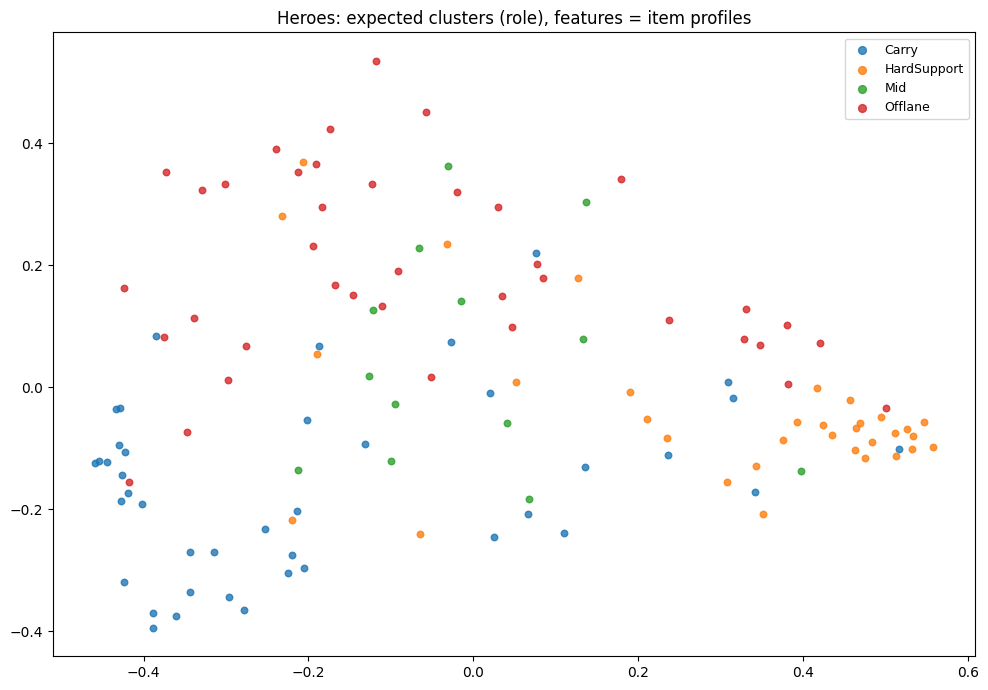

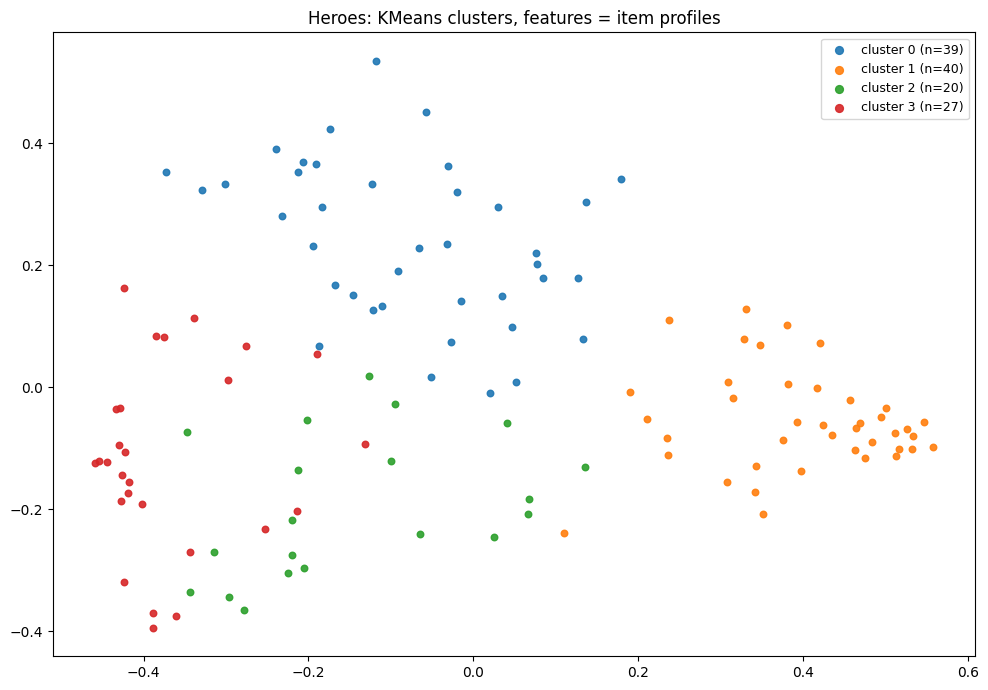

[cluster_items] ARI= 0.23178352624099144


In [ ]:
hero_to_role = {}
for hero in g.subjects(RDF.type, DOTA.Hero):
    role = next(g.objects(hero, DOTA.hasRole), None)
    if role is None:
        continue
    hero_to_role[str(hero)] = uri_to_id(str(role))

rows = []
for x in item_usage:
    role = hero_to_role.get(x.hero)
    if role is None:
        continue
    rows.append({"hero": x.hero, "item": x.item, "pick": x.pick_count, "role": role})

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No item-usage rows available for role clustering.")

agg = df.groupby(["hero", "item"], as_index=False)["pick"].sum()
mat = agg.pivot_table(index="hero", columns="item", values="pick", fill_value=0)

heroes_sorted = sorted(mat.index)
X_items = mat.loc[heroes_sorted].to_numpy(dtype=np.float32)
X_items = np.log1p(X_items)
X_items = normalize(X_items, norm="l2")

labels_items = [hero_to_role[h] for h in heroes_sorted]
unique_labels2 = sorted(set(labels_items))
label_to_int2 = {lab: i for i, lab in enumerate(unique_labels2)}
y_true2 = np.array([label_to_int2[x] for x in labels_items], dtype=np.int64)

n_clusters2 = len(unique_labels2)
kmeans2 = KMeans(n_clusters=n_clusters2, random_state=SEED, n_init="auto")
y_pred2 = kmeans2.fit_predict(X_items)

pca2 = PCA(n_components=2, random_state=SEED)
X2_items = pca2.fit_transform(X_items)

plt.figure(figsize=(10, 7))
for lab in unique_labels2:
    idx = [i for i, x in enumerate(labels_items) if x == lab]
    plt.scatter(X2_items[idx, 0], X2_items[idx, 1], s=22, alpha=0.8, label=lab)
plt.title("Heroes: expected clusters (role), features = item profiles")
plt.legend(markerscale=1.2, fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
for cid in range(n_clusters2):
    idx = np.where(y_pred2 == cid)[0]
    if idx.size == 0:
        continue
    plt.scatter(X2_items[idx, 0], X2_items[idx, 1], s=22, alpha=0.9, label=f"cluster {cid} (n={idx.size})")
plt.title("Heroes: KMeans clusters, features = item profiles")
plt.legend(markerscale=1.2, fontsize=9)
plt.tight_layout()
plt.show()

ari_items = float(adjusted_rand_score(y_true2, y_pred2))
print("[cluster_items] ARI=", ari_items)


## 8) Классификация (XGBoost): предсказание исхода матчапа

Цель: по паре героев `(forHero, vsHero)` предсказать класс матчапа:

- `adv`, если `vs_win_rate ≥ 0.55`
- `dis`, если `vs_win_rate ≤ 0.45`
- `even` иначе

Сравниваем три варианта:

1) XGBoost на признаках из KGE-эмбеддингов,
2) baseline: всегда предсказывать самый частый класс,
3) baseline: XGBoost на one-hot для `(forHero, vsHero)`.


In [ ]:
rows = []
for m in matchups:
    if m.for_hero not in mappings.entity_to_id or m.vs_hero not in mappings.entity_to_id:
        continue
    rows.append(
        {
            "forHero": m.for_hero,
            "vsHero": m.vs_hero,
            "gamesPlayed": m.games_played,
            "label": matchup_label_3class(m.vs_win_rate),
        }
    )

df_cls = pd.DataFrame(rows)
train_df = df_cls[df_cls["gamesPlayed"] >= matchup_threshold].copy()
test_df = df_cls[df_cls["gamesPlayed"] < matchup_threshold].copy()

print("train size:", len(train_df), "test size:", len(test_df))

# Признаки на эмбеддингах
emb = get_entity_embeddings(model)


def featurize(sub: pd.DataFrame) -> np.ndarray:
    h_ids = sub["forHero"].map(mappings.entity_to_id).to_numpy(dtype=np.int64)
    t_ids = sub["vsHero"].map(mappings.entity_to_id).to_numpy(dtype=np.int64)
    h = emb[h_ids]
    t = emb[t_ids]
    return np.concatenate([h, t, h * t, np.abs(h - t)], axis=1)


X_train = featurize(train_df)
X_test = featurize(test_df)

y_train_str = train_df["label"].to_numpy()
y_test_str = test_df["label"].to_numpy()
classes = sorted(set(y_train_str) | set(y_test_str))
class_to_id = {c: i for i, c in enumerate(classes)}
id_to_class = {i: c for c, i in class_to_id.items()}

y_train = np.array([class_to_id[x] for x in y_train_str], dtype=np.int64)
y_test = np.array([class_to_id[x] for x in y_test_str], dtype=np.int64)

majority = Counter(y_test).most_common(1)[0][0]
y_pred_major = np.array([majority] * len(y_test), dtype=np.int64)
acc_major = float(accuracy_score(y_test, y_pred_major))

clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=os.cpu_count() or 1,
    objective="multi:softprob",
    num_class=len(classes),
    eval_metric="mlogloss",
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype(np.int64)
acc_emb = float(accuracy_score(y_test, y_pred))

enc = OneHotEncoder(handle_unknown="ignore")
X_train_oh = enc.fit_transform(train_df[["forHero", "vsHero"]])
X_test_oh = enc.transform(test_df[["forHero", "vsHero"]])

clf_oh = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=os.cpu_count() or 1,
    objective="multi:softprob",
    num_class=len(classes),
    eval_metric="mlogloss",
)
clf_oh.fit(X_train_oh, y_train)
y_pred_oh = clf_oh.predict(X_test_oh).astype(np.int64)
acc_oh = float(accuracy_score(y_test, y_pred_oh))

print(
    "[classify]",
    {
        "acc_embeddings": acc_emb,
        "acc_majority": acc_major,
        "acc_one_hot": acc_oh,
        "train_size": float(len(train_df)),
        "test_size": float(len(test_df)),
    },
)

print("\\n=== Classification report (embeddings) ===")
print(
    classification_report(
        [id_to_class[i] for i in y_test],
        [id_to_class[i] for i in y_pred],
        digits=4,
        labels=classes,
    )
)


train size: 11888 test size: 3846
[classify] {'acc_embeddings': 0.5301612064482579, 'acc_majority': 0.43499739989599584, 'acc_one_hot': 0.5353614144565783, 'train_size': 11888.0, 'test_size': 3846.0}
\n=== Classification report (embeddings) ===
              precision    recall  f1-score   support

         adv     0.5377    0.6091    0.5712      1673
         dis     0.5389    0.6049    0.5700      1673
        even     0.1096    0.0160    0.0279       500

    accuracy                         0.5302      3846
   macro avg     0.3954    0.4100    0.3897      3846
weighted avg     0.4826    0.5302    0.5000      3846



## 9) Link Prediction: предсказание недостающих связей `usesItem_<phase>`

В этой постановке мы фиксируем `(Hero, usesItem_<phase>)` и пытаемся выбрать корректный `Item` среди кандидатов:

- берём истинный тестовый триплет `(h, r, t_true)`,
- генерируем негативные, заменяя `t_true` на другие предметы,
- фильтруем негативи по полному `train`,
- ранжируем и считаем MR/MRR/Hits@K.


In [ ]:
def evaluate_link_prediction_tail_replacement(
    model: TransE,
    triples_eval: torch.LongTensor,
    all_train_triples_set: set[tuple[int, int, int]],
    candidate_tail_entities: Sequence[int],
    num_negatives: int,
    seed: int,
    device: torch.device,
) -> tuple[list[int], pd.DataFrame]:
    rng = random.Random(seed)
    model.eval()
    triples_eval = triples_eval.to(device)
    candidate_tail_entities = list(candidate_tail_entities)
    if not candidate_tail_entities:
        raise ValueError("candidate_tail_entities is empty.")

    ranks: list[int] = []
    records: list[dict[str, int | float]] = []

    for i in tqdm(range(triples_eval.shape[0]), desc="linkpred", leave=False):
        h, r, t = map(int, triples_eval[i].tolist())
        candidates: list[tuple[int, int, int]] = [(h, r, t)]
        attempts = 0
        while len(candidates) < 1 + num_negatives and attempts < (1 + num_negatives) * 50:
            attempts += 1
            new_t = candidate_tail_entities[rng.randrange(len(candidate_tail_entities))]
            if new_t == t:
                continue
            cand = (h, r, new_t)
            if cand in all_train_triples_set:
                continue
            candidates.append(cand)

        cand_tensor = torch.tensor(candidates, dtype=torch.long, device=device)
        scores = model(cand_tensor[:, 0], cand_tensor[:, 1], cand_tensor[:, 2]).detach().cpu().numpy()
        true_score = float(scores[0])
        rank = 1 + int(np.sum(scores[1:] > true_score))
        ranks.append(rank)
        records.append({"idx": i, "rank": rank, "true_score": true_score, "num_candidates": len(candidates)})

    return ranks, pd.DataFrame.from_records(records)


In [ ]:
item_ids = []
for it in g.subjects(RDF.type, DOTA.Item):
    its = str(it)
    if its in mappings.entity_to_id:
        item_ids.append(mappings.entity_to_id[its])

uses_prefix = str(DOTA) + "usesItem_"
test_item_triples = [tr for tr in test_triples if tr[1].startswith(uses_prefix)]
print("test_item_triples:", len(test_item_triples))

if not test_item_triples:
    raise RuntimeError(
        "Нет тестовых item-триплетов. Попробуйте увеличить ITEM_QUANTILE, "
        "чтобы больше item-связей ушло в test (например 0.5 или 0.75)."
    )

test_item_tensor = triples_to_tensor(test_item_triples, mappings)

ranks_test, test_df = evaluate_link_prediction_tail_replacement(
    model=model,
    triples_eval=test_item_tensor,
    all_train_triples_set=train_all_set,
    candidate_tail_entities=item_ids,
    num_negatives=TEST_NEGATIVES,
    seed=SEED + 1,
    device=DEVICE,
)
metrics_test = rank_metrics_from_ranks(ranks_test)
print(f"[linkpred@test:items] triples={len(test_item_triples)} metrics={metrics_test}")

(test_df).to_csv(OUT_DIR / "test_ranks_items.csv", index=False)
with (OUT_DIR / "metrics_test.json").open("w", encoding="utf-8") as f:
    json.dump(metrics_test, f, ensure_ascii=False, indent=2)


test_item_triples: 5770


linkpred:   0%|          | 0/5770 [00:00<?, ?it/s]

[linkpred@test:items] triples=5770 metrics={'MR': 10.113518197573656, 'MRR': 0.2864503295849468, 'Hits@1': 0.1389948006932409, 'Hits@3': 0.30398613518197576, 'Hits@10': 0.6447140381282496}


### (Дополнительно) Пример: top‑K рекомендаций предметов для героя и фазы

Это уже не метрика, а демонстрация “какие связи модель считает вероятными”, если отфильтровать уже известные факты из `train`.

In [ ]:
def recommend_items_for_hero_phase(
    hero_uri: str,
    phase_relation_uri: str,
    top_k: int = 10,
) -> pd.DataFrame:
    if hero_uri not in mappings.entity_to_id:
        raise KeyError("hero_uri not in mappings")
    if phase_relation_uri not in mappings.relation_to_id:
        raise KeyError("phase_relation_uri not in mappings")

    h_id = mappings.entity_to_id[hero_uri]
    r_id = mappings.relation_to_id[phase_relation_uri]

    # Считаем score для всех item-кандидатов
    cand = np.array(item_ids, dtype=np.int64)
    heads = torch.full((len(cand),), h_id, dtype=torch.long, device=DEVICE)
    rels = torch.full((len(cand),), r_id, dtype=torch.long, device=DEVICE)
    tails = torch.from_numpy(cand).to(DEVICE)

    with torch.no_grad():
        scores = model(heads, rels, tails).detach().cpu().numpy()

    # Фильтруем уже известные train-триплеты
    known = train_all_set
    mask = []
    for t_id in cand.tolist():
        mask.append((h_id, r_id, t_id) not in known)
    mask = np.array(mask, dtype=bool)

    cand2 = cand[mask]
    scores2 = scores[mask]

    order = np.argsort(-scores2)[:top_k]
    best_t = cand2[order]
    best_s = scores2[order]

    return pd.DataFrame(
        {
            "item": [uri_to_id(mappings.id_to_entity[i]) for i in best_t.tolist()],
            "item_uri": [mappings.id_to_entity[i] for i in best_t.tolist()],
            "score": best_s.tolist(),
        }
    )


# Выберем пример героя и фазу автоматически
hero_example = heroes_uris[0]
phase_rels = sorted({r for _, r, _ in train_triples if r.startswith(uses_prefix)})
phase_rel_example = phase_rels[0]

print("hero:", uri_to_id(hero_example))
print("relation:", uri_to_id(phase_rel_example))

display(recommend_items_for_hero_phase(hero_example, phase_rel_example, top_k=10))


hero: AntiMage
relation: usesItem_early_game_items


,item,item_uri,score
0,NullTalisman,http://dota2.ontology#NullTalisman,-12.276397
1,BladeofAlacrity,http://dota2.ontology#BladeofAlacrity,-12.746272
2,Chainmail,http://dota2.ontology#Chainmail,-12.822231
3,Diadem,http://dota2.ontology#Diadem,-12.907430
4,TranquilBoots,http://dota2.ontology#TranquilBoots,-12.914040
5,MithrilHammer,http://dota2.ontology#MithrilHammer,-12.937393
6,PhaseBoots,http://dota2.ontology#PhaseBoots,-12.955681
7,StaffofWizardry,http://dota2.ontology#StaffofWizardry,-12.978374
8,BootsofTravel,http://dota2.ontology#BootsofTravel,-13.095249
9,MorbidMask,http://dota2.ontology#MorbidMask,-13.102280
